<a href="https://colab.research.google.com/github/SelinaZ07/NASA-Space-App-challenge/blob/main/NASA_backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install the required packages
!pip install sentence-transformers scikit-learn pandas numpy umap-learn matplotlib joblib openai
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install sentence-transformers
!pip install -U transformers==4.44.2
!pip install -U sentence-transformers==2.7.0

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.1
    Uninstalling sentence-transformers-5.1.1:
      Successfully uninstalled sentence-transformers-5.1.1


In [2]:
from google.colab import files
uploaded = files.upload()   # choose your CSV file

Saving SB_publication_PMC.csv to SB_publication_PMC.csv


In [3]:
#embeddings
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

df = pd.read_csv("/content/SB_publication_PMC.csv")               # must have 'title' col
df = df.drop_duplicates(subset=["Title"]).reset_index(drop=True)
titles = df['Title'].astype(str).tolist()

model = SentenceTransformer('all-MiniLM-L6-v2')   # or 'all-mpnet-base-v2'
embeddings = model.encode(titles, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
# embeddings: shape (n_titles, dim)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
from sklearn.decomposition import PCA

# reduce to 50 dimensions (good balance for clustering)
pca = PCA(n_components=50, random_state=42)
X = pca.fit_transform(embeddings)

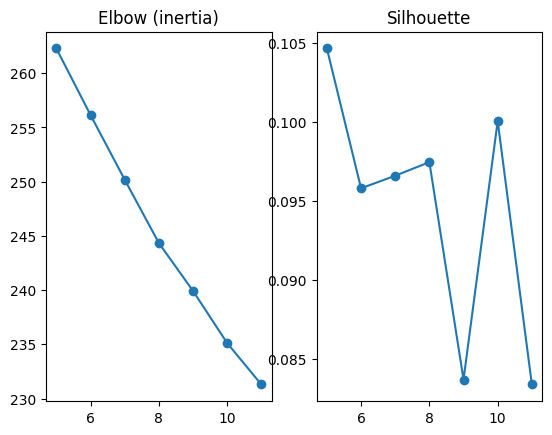

In [5]:
#Elbow method to find k value
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ks = list(range(5,12))
inertias, sil_scores = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, km.labels_))

plt.subplot(1,2,1); plt.plot(ks, inertias, '-o'); plt.title("Elbow (inertia)")
plt.subplot(1,2,2); plt.plot(ks, sil_scores, '-o'); plt.title("Silhouette")
plt.show()

In [ ]:
k = 10  # chosen after diagnostics
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
labels = kmeans.fit_predict(X)
df['cluster'] = labels

#Plot the k-means clustering graphs
import numpy as np
from sklearn.metrics import silhouette_samples

# sizes
sizes = df.groupby('cluster').size().sort_values(ascending=False)
print(sizes)

# silhouette per sample
s_samples = silhouette_samples(X, labels)
df['silhouette'] = s_samples

# representative titles per cluster
reps = {}
for c in range(k):
    idx = np.where(labels == c)[0]
    centroid = kmeans.cluster_centers_[c]
    # distance in PCA space:
    dists = np.linalg.norm(X[idx] - centroid, axis=1)
    reps[c] = df.iloc[idx[np.argmin(dists)]]['Title']
    print(f"Cluster {c} ({len(idx)}): rep title: {reps[c]}")